**FIY**
* Python 3.6.4
* matplotlib 2.0.2
* pandas 0.20.1
* jupyter 1.0.0
* notebook 5.4.0
* numpy 1.14.1
* scipy 1.0.0
* statsmodels 0.8.0

## Анализ данных в задаче кредитного скоринга

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

* `LIMIT_BAL`: размер кредитного лимита (в том числе и на семью клиента)
* `SEX`: пол клиента (`1` = мужской, `2` = женский)
* `EDUCATION`: образование (`0` = доктор, `1` = магистр; `2` = бакалавр; `3` = выпускник школы; `4` = начальное образование; `5` = прочее; `6` = нет данных).
* `MARRIAGE`: (`0` = отказываюсь отвечать; `1` = замужем/женат; `2` = холост; `3` = нет данных).
* `AGE`: возраст в годах
* `PAY_0` - `PAY_6` : История прошлых платежей по кредиту. `PAY_6` - платеж в апреле, ... `PAY_0` - платеж в сентябре. Платеж = (`0` = исправный платеж, `1` = задержка в один месяц, `2` = задержка в 2 месяца, …)
* `BILL_AMT1` - `BILL_AMT6`: задолженность, `BILL_AMT6` - на апрель, `BILL_AMT1` - на сентябрь
* `PAY_AMT1` - `PAY_AMT6`: сумма уплаченная в `PAY_AMT6` - апреле, …, `PAY_AMT1` - сентябре
* `default` - индикатор невозврата денежных средств

In [48]:
from math import sqrt
from typing import Sequence

import numpy
import pandas
from matplotlib import pyplot
from scipy import stats
from statsmodels.stats.multitest import multipletests

%matplotlib notebook
pandas.set_option('display.max_columns', 500)

In [3]:
dataset = pandas.read_csv('credit_card_default_analysis.csv')
dataset.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
pandas.DataFrame(dataset['default'].value_counts())

,default
0,23364
1,6636


### Размер кредитного лимита (`LIMIT_BAL`)

В двух группах, тех людей, кто вернул кредит (`default = 0`) и тех, кто его не вернул (`default = 1`) проверьте гипотезы:
* о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки
* о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.

Значимы ли полученные результаты с практической точки зрения?

Давайте изобразим исследуемую величину:

In [5]:
non_default_limit_bal = dataset[dataset['default'] == 0]['LIMIT_BAL']
default_limit_bal = dataset[dataset['default'] == 1]['LIMIT_BAL']

<IPython.core.display.Javascript object>


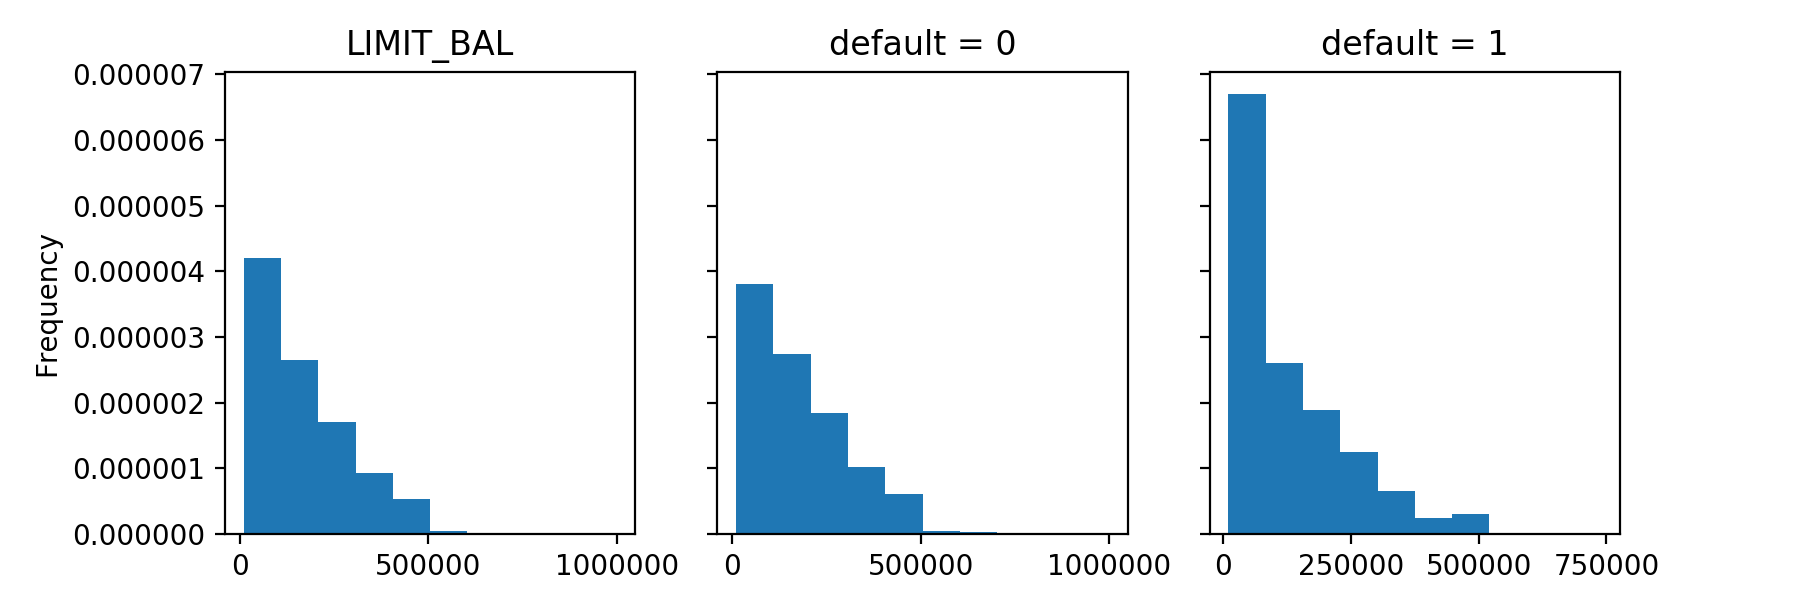

In [122]:
_, axes = pyplot.subplots(nrows=1, ncols=3, sharey='row', figsize=(9, 3))

dataset['LIMIT_BAL'].plot.hist(ax=axes[0], normed=True).set_title('LIMIT_BAL')
non_default_limit_bal.plot.hist(ax=axes[1], normed=True).set_title('default = 0')
default_limit_bal.plot.hist(ax=axes[2], normed=True).set_title('default = 1')
pyplot.show()

Пока вижу, что у группы `default = 1` есть скос распределения влево.

Перед применением критериев хотелось бы убедиться, что общие формы этих распределений не сильно отличаются. Изобразим распределение логарифмов исследуемой величины в надежде привести ее к более-менее нормальной форме:

<IPython.core.display.Javascript object>


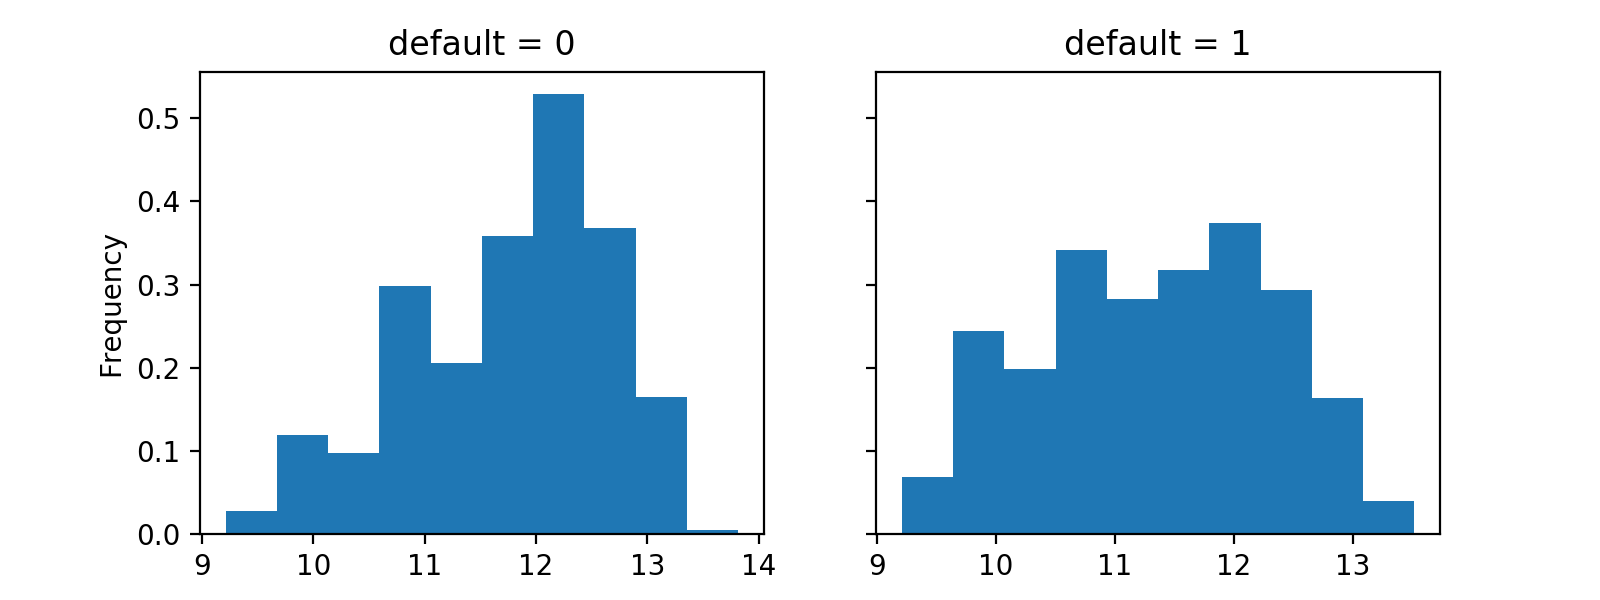

In [125]:
_, axes = pyplot.subplots(nrows=1, ncols=2, sharey='row', figsize=(8, 3))

non_default_limit_bal.apply(numpy.log).plot.hist(ax=axes[0], normed=True).set_title('default = 0')
default_limit_bal.apply(numpy.log).plot.hist(ax=axes[1], normed=True).set_title('default = 1')
pyplot.show()

Не так уж и плохо.

Давайте проверим, что у этих двух групп медианы лимита значимо отличаются. Проверять будем бутстрап-критерием равенство математических ожиданий медиан в группах против двухсторонней альтернативы. Соответственно, нулевая гипотеза: математические ожидания медиан равны.

In [7]:
def sample(data: Sequence, n_samples: int):
    return data[numpy.random.randint(0, len(data), (n_samples, len(data)))]

def statistics_intervals(statistics: Sequence, alpha: float):
    return numpy.percentile(statistics, [100 * alpha / 2, 100 * (1 - alpha / 2)])

numpy.random.seed(42)
n_samples = 100
non_default_limit_bal_medians = numpy.median(sample(non_default_limit_bal.values, n_samples), axis=1)
default_limit_bal_medians = numpy.median(sample(default_limit_bal.values, n_samples), axis=1)
statistics_intervals(default_limit_bal_medians - non_default_limit_bal_medians, 0.05)

array([-70000., -60000.])

Действительно: кредитный лимит у "невозвращенцев" меньше кредитного лимита "возвращенцев". 95%-ый доверительный интервал для разности лимитов первых и вторых – `(-70000, -60000)`, ноль в интервале не содержится.

Давайте теперь проверим равенство распределений. И здесь нам поможет критерий Манна-Уитни для двухвыброчной задачи с независимыми выборками. Нулевая гипотеза: распределения равны против общей альтернативы – распределения равны, но с ненулевым сдвигом.

In [8]:
stats.mannwhitneyu(default_limit_bal.values, non_default_limit_bal.values, alternative='two-sided')

MannwhitneyuResult(statistic=59257217.5, pvalue=1.2255485818223303e-189)

Нулевая гипотеза уверенно отвергается, средние двух выборок отличаются. Вероятно, этот признак полезен.

### Пол (`SEX`)

Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия).

Так, давайте посмотрим на матрицу сопряженности признака `SEX` и искомой метки `default`.

In [17]:
sex_default_crosstab = pandas.crosstab(dataset['SEX'], dataset['default'])
sex_default_crosstab

default,0,1
SEX,,
1,9015,2873
2,14349,3763


Ну и на графики заодно.

<IPython.core.display.Javascript object>


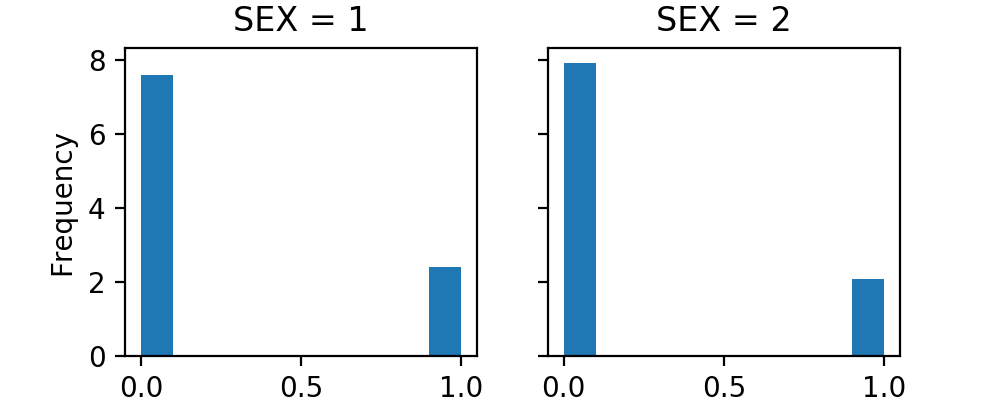

In [74]:
_, axes = pyplot.subplots(nrows=1, ncols=2, sharey='row', figsize=(5, 2))

dataset[dataset['SEX'] == 1]['default'].plot.hist(ax=axes[0], normed=True).set_title('SEX = 1')
dataset[dataset['SEX'] == 2]['default'].plot.hist(ax=axes[1], normed=True).set_title('SEX = 2')
pyplot.show()

Хм. Сходу не видно, отличаются ли доли для `default` в обоих группах по полу. Давайте применим критерий для сравнения долей. Нулевая гипотеза: доли "невозвращенцев" в обоих группах не различаются – против общей альтернативы.

In [30]:
def proportions_diff_z_stat_ind(s1: int, n1: int, s2: int, n2: int) -> float:
    p1 = s1 / n1
    p2 = s2 / n2 
    P = (s1 + s2) / (n1 + n2)
    
    return (p1 - p2) / sqrt(P * (1 - P) * (1 / n1 + 1 / n2))


def proportions_diff_z_test(z_stat: float, alternative='two-sided') -> float:
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)


'P-value: %s' % proportions_diff_z_test(proportions_diff_z_stat_ind(
    sex_default_crosstab[1][1],  # default = 1, SEX = 1
    sex_default_crosstab[0][1] + sex_default_crosstab[1][1],  # SEX = 1
    sex_default_crosstab[1][2],  # default = 1, SEX = 2
    sex_default_crosstab[0][2] + sex_default_crosstab[1][2],  # SEX = 2
))

'P-value: 4.472866521609831e-12'

Нулевая гипотеза отвергается, доли значимо различаются. Давайте посмотрим на доверительный интервал для разности долей:

In [29]:
def proportions_diff_confint_ind(s1: int, n1: int, s2: int, n2: int, alpha=0.05):    
    z = stats.norm.ppf(1 - alpha / 2)
    
    p1 = s1 / n1
    p2 = s2 / n2
    
    left_boundary = (p1 - p2) - z * sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    right_boundary = (p1 - p2) + z * sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    
    return (left_boundary, right_boundary)


proportions_diff_confint_ind(
    sex_default_crosstab[1][1],  # default = 1, SEX = 1
    sex_default_crosstab[0][1] + sex_default_crosstab[1][1],  # SEX = 1
    sex_default_crosstab[1][2],  # default = 1, SEX = 2
    sex_default_crosstab[0][2] + sex_default_crosstab[1][2],  # SEX = 2
)

(0.024207372179792706, 0.0436115585708172)

По всей видимости, доля неплательщиков среди представителей пола `1` значимо выше, доверительный интервал: `(0.0242, 0.0436)`. Хороший признак.

### Образование (`EDUCATION`)

* Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.
* Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек.
* Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости?
* Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? Наоборот, не отдаст долг?

Ну давайте снова посмотрим на таблицу сопряженности (пока просто без ожидаемых значений):

In [32]:
education_crosstab = pandas.crosstab(dataset['EDUCATION'], dataset['default'])
education_crosstab

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


И на графики – просят же.

<IPython.core.display.Javascript object>


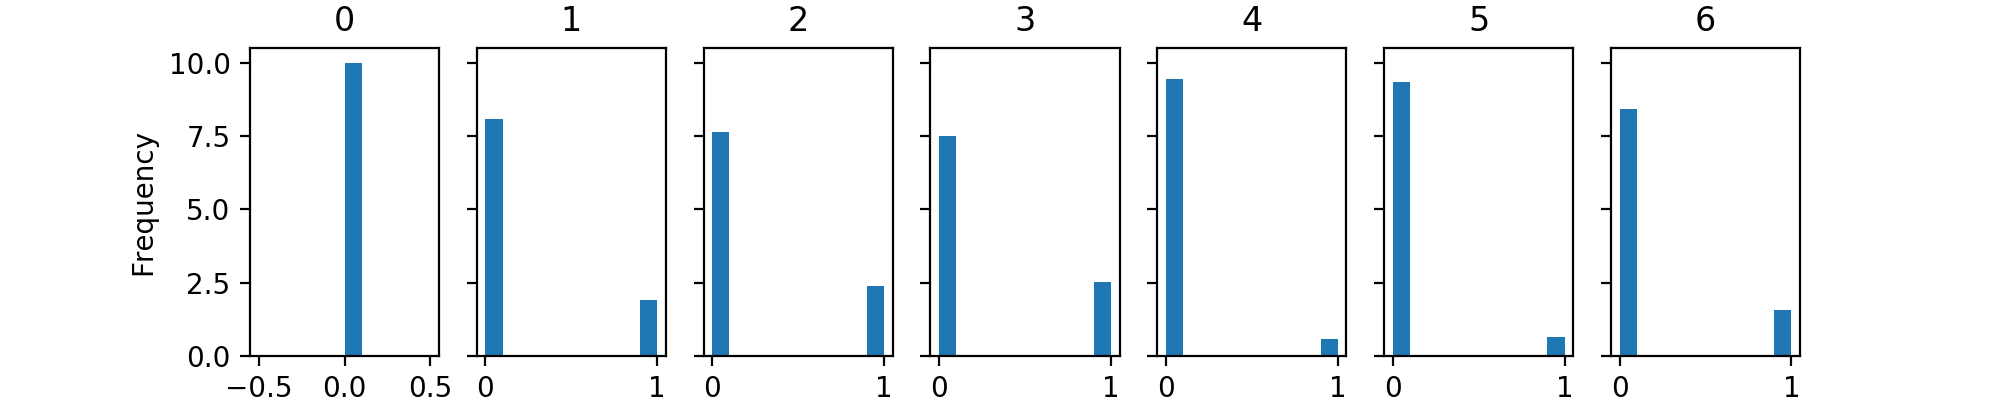

In [77]:
_, axes = pyplot.subplots(nrows=1, ncols=7, sharey='row', figsize=(10, 2))

for education in range(7):
    dataset[dataset['EDUCATION'] == education]['default'].plot.hist(ax=axes[education], normed=True).set_title(f'{education}')
pyplot.show()

У меня есть подозрение, что образование влияет на возврат долга. Давайте проверим это формально. Будем использовать критерий хи-квадрат для категориальных признаков. Нулевая гипотеза: коррелляция между этими двумя признаками отсутствует – против общей альтернативы.

In [89]:
chi2, p, dof, expected = stats.chi2_contingency(education_crosstab)
print(f'P-value: {p:E}')

P-value: 1.233263E-32


Критерий хи-квадрат отвергает гипотезу о взаимной независимости признаков. Давайте посмотрим на разность между фактическими и ожидаемыми значениями:

In [104]:
expected_education_crosstab = pandas.DataFrame(expected, index=education_crosstab.index)
education_crosstab - expected_education_crosstab

default,0,1
EDUCATION,,
0,3.0968,-3.0968
1,305.4020,-305.4020
2,-226.5640,226.5640
3,-149.3596,149.3596
4,20.2076,-20.2076
5,43.9360,-43.9360
6,3.2812,-3.2812


Хорошо, но давайте лучше посмотрим на долю неплательщиков в каждой группе:

In [107]:
def crosstab_to_proportion(crosstab: pandas.DataFrame) -> pandas.DataFrame:
    return pandas.DataFrame(crosstab.apply(lambda row: row[1] / (row[0] + row[1]), axis=1), columns=['proportion'])

crosstab_to_proportion(education_crosstab)

,proportion
EDUCATION,
0,0.000000
1,0.192348
2,0.237349
3,0.251576
4,0.056911
5,0.064286
6,0.156863


Кажется, лучше всего выплачивают кредиты доктора. А вот выпускникам школы лучше не доверять.

И давайте теперь напоследок отмасштабируем разности между наблюдаемыми и ожидаемыми значениями: посмотрим на разности соответствующих долей:

In [108]:
crosstab_to_proportion(education_crosstab) - crosstab_to_proportion(expected_education_crosstab)

,proportion
EDUCATION,
0,-0.221200
1,-0.028852
2,0.016149
3,0.030376
4,-0.164289
5,-0.156914
6,-0.064337


Ну что ж, похоже, что это тоже полезный признак.

### Семейное положение (`MARRIAGE`)

Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

Как обычно посмотрим на данные:

<IPython.core.display.Javascript object>


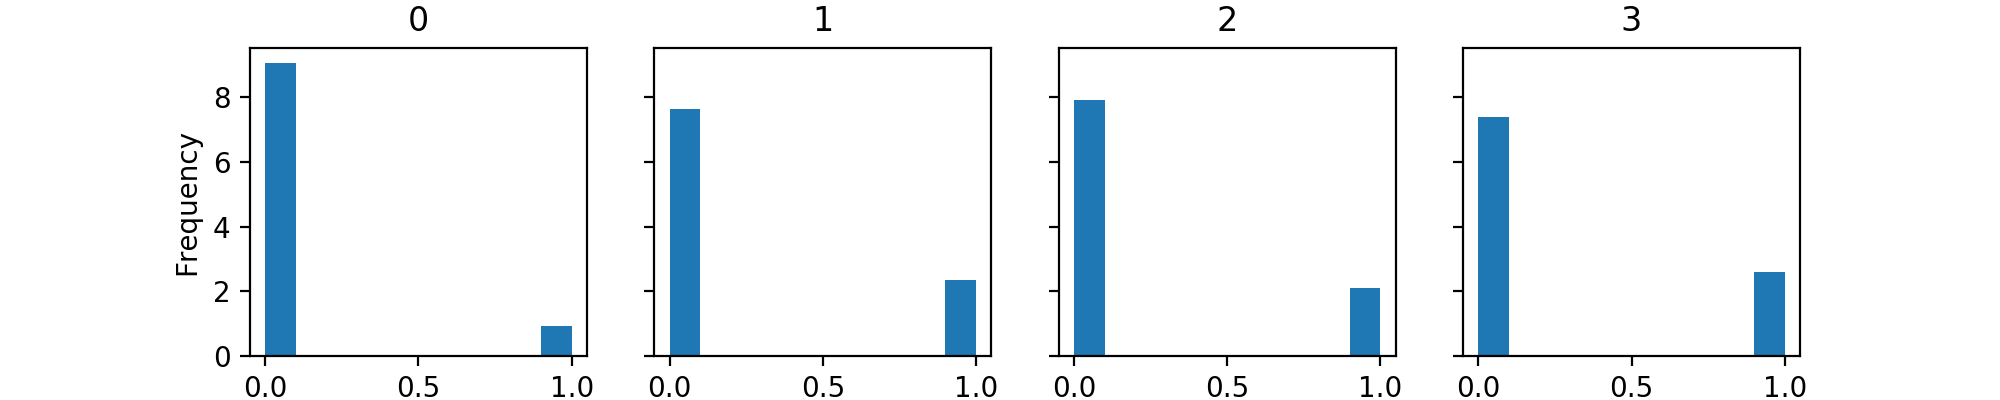

In [113]:
_, axes = pyplot.subplots(nrows=1, ncols=4, sharey='row', figsize=(10, 2))

for marriage in range(4):
    dataset[dataset['MARRIAGE'] == marriage]['default'].plot.hist(ax=axes[marriage], normed=True).set_title(f'{marriage}')
pyplot.show()

In [109]:
marriage_crosstab = pandas.crosstab(dataset['MARRIAGE'], dataset['default'])
marriage_crosstab

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


Вроде бы графики немного отличаются, но сходу непонятно, есть ли между признаками взаимосвязь.

Давайте проверим формально, связаны ли эти признаки (да-да, снова скажу, что критерий хи-квадрат для нулевой гипотезы о взаимной независимости этих величин против общей альтернативы):

In [114]:
chi2, p, dof, expected = stats.chi2_contingency(marriage_crosstab)
print(f'P-value: {p:E}')

P-value: 8.825862E-08


Эти признаки действительно связаны, нулевая гипотеза отвергается на очень низком уровне. Давайте измерим взаимосвязь, а в качестве меры выберем коэффициент V Крамера:

In [117]:
def cramers_stat(observed: numpy.array) -> float:
    """
    https://stackoverflow.com/a/38032115/359730
    """
    chi2, *_ = stats.chi2_contingency(observed)
    n = observed.sum()
    return sqrt(chi2 / (n * (min(observed.shape) - 1)))


print(f'V: {cramers_stat(marriage_crosstab.values):.4f}')

V: 0.0345


Тоже хороший признак.

### Возраст (`AGE`)

Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы:
* о равенстве медианных значений возрастов людей
* о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения?

Дежа вю. Кажется, в самом первом вопросе что-то такое я уже делал. Давайте повторим.

In [118]:
non_default_age = dataset[dataset['default'] == 0]['AGE']
default_age = dataset[dataset['default'] == 1]['AGE']

<IPython.core.display.Javascript object>


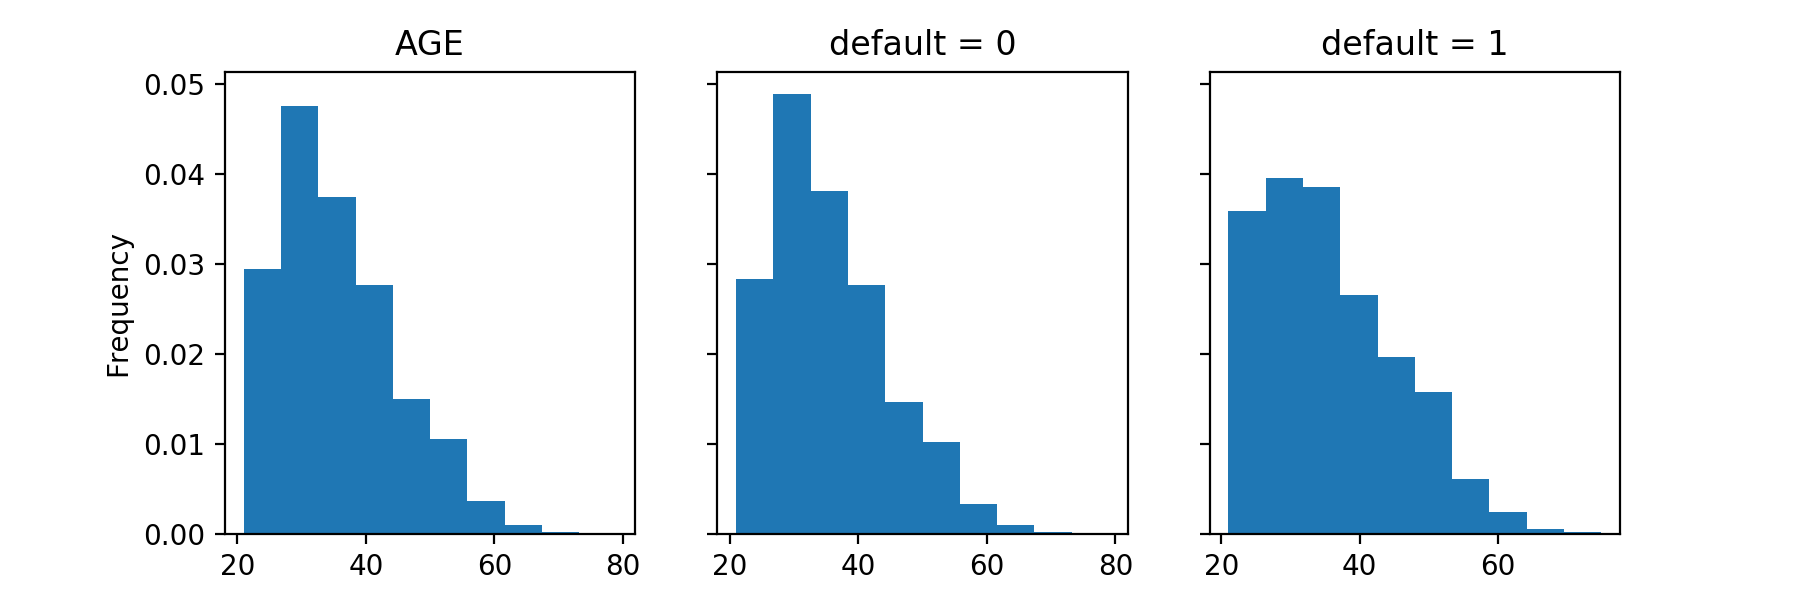

In [128]:
_, axes = pyplot.subplots(nrows=1, ncols=3, sharey='row', figsize=(9, 3))

dataset['AGE'].plot.hist(ax=axes[0], normed=True).set_title('AGE')
non_default_age.plot.hist(ax=axes[1], normed=True).set_title('default = 0')
default_age.plot.hist(ax=axes[2], normed=True).set_title('default = 1')
pyplot.show()

Вот здесь мне совсем не очевидно, есть ли разница между двумя группами по признаку `default`. Давайте проделаем те же проверки критериев.

Для начала бутстрап-критерий для проверки равенства математических ожиданий медиан.

In [132]:
numpy.random.seed(42)
n_samples = 100
non_default_age_medians = numpy.median(sample(non_default_age.values, n_samples), axis=1)
default_age_medians = numpy.median(sample(default_age.values, n_samples), axis=1)
statistics_intervals(default_age_medians - non_default_age_medians, 0.05)

array([0., 1.])

Упс, 95%-ый доверительный интервал касается нуля. Гипотеза не отвергается на уровне значимости `0.05`. Что насчет нулевой гипотезы о равенстве распределений?

In [133]:
stats.mannwhitneyu(default_age.values, non_default_age.values, alternative='two-sided')

MannwhitneyuResult(statistic=78076624.5, pvalue=0.3725035434898616)

Гипотеза о равенстве распределений не отвергается, p-value слишком большой. Вряд ли этот признак имеет практическое значение.

**Поздравляю, вы дочитали этот отчет! 🎉**